In [1]:
import tensorflow as tf # Imports tensorflow
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization,Conv2D, MaxPooling2D,concatenate, Conv2DTranspose, Add,  GlobalAveragePooling2D,Input,  Multiply, UpSampling2D, Resizing
from tensorflow.keras.metrics import Accuracy,Recall,Precision,AUC
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.image import resize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import seaborn as sns
#import imblearn
#from keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import os
import sklearn.metrics as m
from glob import glob
from sklearn.model_selection import train_test_split
import skimage.color
import skimage.filters
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
gr_shape=(128,128,1)
img_shape = (128,128,3)
input_dir="C:/nidhin/abu project/LIDC-IDRI-slices"
images=[]
masks=[]
y=[]
Thres = 5000/255

In the provided code, the following preprocessing steps are performed:

1. Loading Images and Masks:
   - Images and masks are loaded from the specified directories using `image.load_img()` from the Keras preprocessing module. They are resized to the `img_shape`.
   - The images are stored in the `images` list, and the masks are stored in separate lists (`mask0`, `mask1`, `mask2`, `mask3`).

2. Processing Masks and Labels:
   - For each nodule, the white pixel sum is computed for each mask (`mask0`, `mask1`, `mask2`, `mask3`).
   - If the count of white pixels exceeds the threshold (`Thres`) for more than 2 masks, it is labeled as 1 (positive), and the mask with the maximum white pixel sum is chosen. Otherwise, it is labeled as 0 (negative), and the mask with the minimum white pixel sum is chosen.
   - The images, masks, and labels are stored in lists (`images`, `masks`, `y`).

3. Normalization:
   - Images and masks are divided by 255 to normalize pixel values between 0 and 1.

4. Handling Missing Values:
   - Any NaN values in images and masks are replaced with 0 using `np.nan_to_num()`.

5. Data Augmentation:
   - No explicit data augmentation is performed in this snippet.

6. Data Concatenation:
   - Additional data is added to the training set (`x_train_added`, `y_train_added`) by appending a portion of the test set (`x_test`, `y_test`).

Overall, the preprocessing in this code involves loading images and masks, processing masks to determine labels, normalizing the pixel values, handling missing values, and concatenating data for training.

In [3]:
# Iterate over patients in the input directory
for patient in os.listdir(input_dir):
    # Check if the item is a directory
    patient_dir = os.path.join(input_dir, patient)
    if not os.path.isdir(patient_dir):
        continue

    # Break loop if images list exceeds 10000
    if len(images) > 10000:
        break

    # Iterate over nodules in the patient directory
    for nodule in os.listdir(patient_dir):
        nodule_dir = os.path.join(patient_dir, nodule)
        if not os.path.isdir(nodule_dir):
            continue

        mask0 = []
        mask1 = []
        mask2 = []
        mask3 = []

        # Load images
        for filename in glob(os.path.join(nodule_dir, 'images', '*.png')):
            img = image.load_img(filename, target_size=img_shape)
            img = np.asarray(img)
            images.append(img)

        # Load masks
        for i, mask_dir in enumerate([mask0, mask1, mask2, mask3]):
            for filename in glob(os.path.join(nodule_dir, f'mask-{i}', '*.png')):
                img = image.load_img(filename, target_size=img_shape)
                img = np.asarray(img)
                mask_dir.append(img)

        # Process masks and labels
        for i in range(len(mask0)):
            white_sum = np.array([mask.sum() for mask in [mask0[i], mask1[i], mask2[i], mask3[i]]])
            cnt = np.sum(white_sum > Thres)
            if cnt > 2:
                y.append(1)
                max_index = white_sum.argmax()
                masks.append([mask0[i], mask1[i], mask2[i], mask3[i]][max_index])
            else:
                y.append(0)
                min_index = white_sum.argmin()
                masks.append([mask0[i], mask1[i], mask2[i], mask3[i]][min_index])

In [4]:
images=np.array(images)/255
masks=np.array(masks)/255
label=np.array(y)
print(images.shape)
print(masks.shape)
print(label.shape)

(10011, 128, 128, 3)
(10011, 128, 128, 3)
(10011,)


In [5]:
yy=pd.DataFrame(label)
yy.value_counts()

1    5097
0    4914
Name: count, dtype: int64

In [6]:
x_train,x_test,y_train,y_test,mask_train,mask_test = train_test_split(images,label,masks,train_size=0.8, random_state=7)
print(x_train.shape)
print(mask_train.shape)

(8008, 128, 128, 3)
(8008, 128, 128, 3)


In [7]:
images = np.nan_to_num(images)
masks = np.nan_to_num(masks )
np.isnan(masks).sum()
masks.shape

(10011, 128, 128, 3)

In [8]:
x_train_added = np.vstack([x_train,x_test[:2000]])
y_train_added = np.concatenate((y_train,y_test[:2000]))
print(x_test.shape)
print(mask_test.shape)
Name='UNET123'


(2003, 128, 128, 3)
(2003, 128, 128, 3)


In [24]:
def mean_iou(y_true, y_pred):
    # Define a function to calculate IoU
    def iou(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + K.epsilon()) / (union + K.epsilon()), axis=0)
        return iou
    
    # Compute IoU for each class
    ious = iou(y_true, y_pred)
    # Take the mean over classes (excluding the background)
    return K.mean(ious)

# Define the Matthews correlation coefficient (MCC) custom metric function
def mcc(y_true, y_pred):
    y_pred_pos = tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = tf.keras.backend.sum(y_pos * y_pred_pos)
    tn = tf.keras.backend.sum(y_neg * y_pred_neg)

    fp = tf.keras.backend.sum(y_neg * y_pred_pos)
    fn = tf.keras.backend.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = tf.keras.backend.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + tf.keras.backend.epsilon())

    return numerator / (denominator + tf.keras.backend.epsilon())

In [25]:
Name='UNET123'
def segment_model():
    inputs = keras.Input(shape=img_shape, name="img")
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1) (c1)
    down1 = MaxPooling2D((2, 2)) (c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (down1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.2) (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2) (c3)    
    p3 = MaxPooling2D((2, 2)) (c3)
    
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2) (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3) (c5)
    
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2) (c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
    c7 = BatchNormalization()(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
    c8 = BatchNormalization()(c8)
    
    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
    c9 = BatchNormalization()(c9)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)
    model = keras.Model(inputs, outputs, name=Name)
    # model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01), 
    #               loss='binary_crossentropy', metrics=['accuracy',Recall(),Precision(),AUC()])
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', metrics=['accuracy',Precision(),Recall(), AUC(),mean_iou, mcc])
    model.summary()
    plot_model(model, to_file=Name+'seg.png',show_shapes= True , show_layer_names=True)
    return model
UNET123 = segment_model()


Model: "UNET123"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 128, 128, 32)         896       ['img[0][0]']                 
                                                                                                  
 batch_normalization_24 (Ba  (None, 128, 128, 32)         128       ['conv2d_36[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_18 (Dropout)        (None, 128, 128, 32)         0         ['batch_normalization_24

In [26]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Specify the path to the saved model
model_path = "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/MODEL/ALEXNET.h5"

# Load the model
model = load_model(model_path)

# Check the model architecture
model.summary()


ValueError: Unknown metric function: 'mean_iou'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [27]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Define your custom metric function
def mean_iou(y_true, y_pred):
    # This is a simplified example; replace with your actual implementation
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32), axis=[1, 2, 3])
    union = tf.reduce_sum(tf.cast(y_true + y_pred, tf.float32), axis=[1, 2, 3])
    smooth = tf.ones_like(intersect)
    iou = tf.reduce_mean((intersect + smooth) / (union - intersect + smooth), axis=0)
    return iou

# Specify the path to the saved model
model_path = 'C:/Users/nidhi/OneDrive/Desktop/paper/New folder/MODEL/UNET123.h5'

# Load the model with the custom_objects parameter
model = load_model(model_path, custom_objects={'mean_iou': mean_iou})

# Check the model architecture
model.summary()


ValueError: Unknown metric function: 'mcc'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [31]:
import pandas as pd

# Replace 'your_file.csv' with the path to your actual CSV file
file_path = "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/alexnetnew.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)



       loss  accuracy    recall  precision       auc  mean_iou       mcc  \
0  0.030950       0.0  0.004113   0.008575  0.881142  0.019945  0.000014   
1  0.016778       0.0  0.006267   0.693422  0.974824  0.034771  0.012008   
2  0.015537       0.0  0.147838   0.646388  0.977903  0.040141  0.210434   
3  0.014995       0.0  0.224383   0.641609  0.978796  0.042988  0.301444   
4  0.014329       0.0  0.249159   0.658557  0.981559  0.046035  0.327607   

   val_loss  val_accuracy  val_recall  val_precision   val_auc  val_mean_iou  \
0  0.017932           0.0    0.000000       0.000000  0.973402      0.033413   
1  0.016117           0.0    0.049734       0.786534  0.979802      0.031272   
2  0.015062           0.0    0.209115       0.635080  0.982110      0.040648   
3  0.014868           0.0    0.155430       0.667160  0.981878      0.041488   
4  0.014605           0.0    0.191159       0.708676  0.984221      0.047117   

    val_mcc  
0  0.000000  
1  0.089234  
2  0.276914  
3  0.2

In [33]:
import pandas as pd

# Replace 'your_file.csv' with the path to your actual CSV file
file_path = "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/UNET123new.csv"
# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)


In [32]:
import pandas as pd

# Replace 'your_file.csv' with the path to your actual CSV file
file_path = "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/coatnetnew.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)


In [34]:
import pandas as pd

# Replace 'your_file.csv' with the path to your actual CSV file
file_path = "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/lidcUnet50new.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)


In [35]:
import pandas as pd

# Replace 'your_file.csv' with the path to your actual CSV file
file_path = "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/vgg19_customnew.csv"
# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)


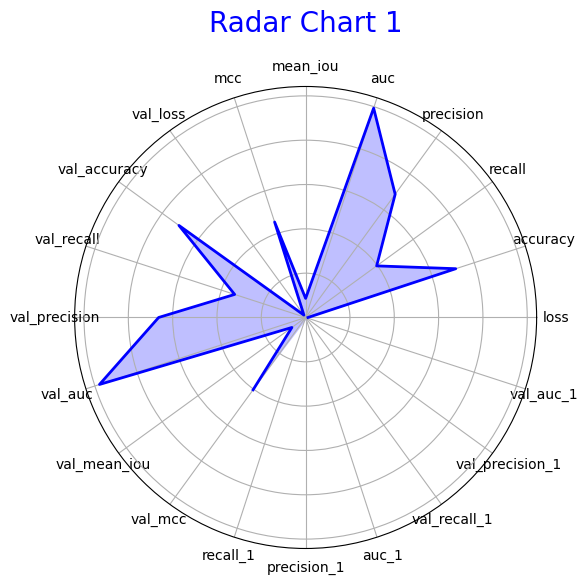

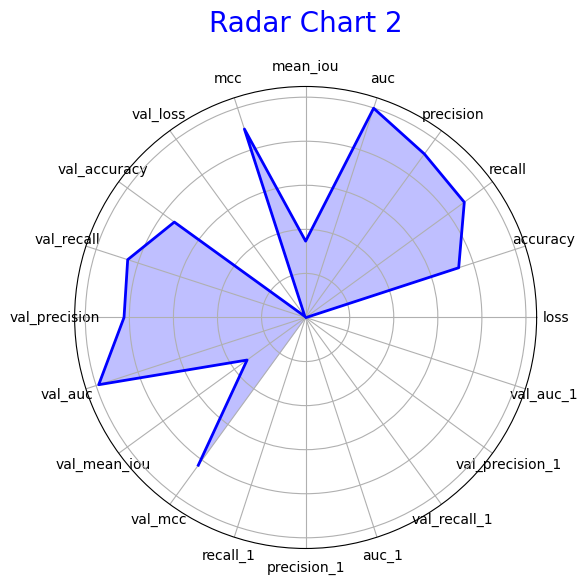

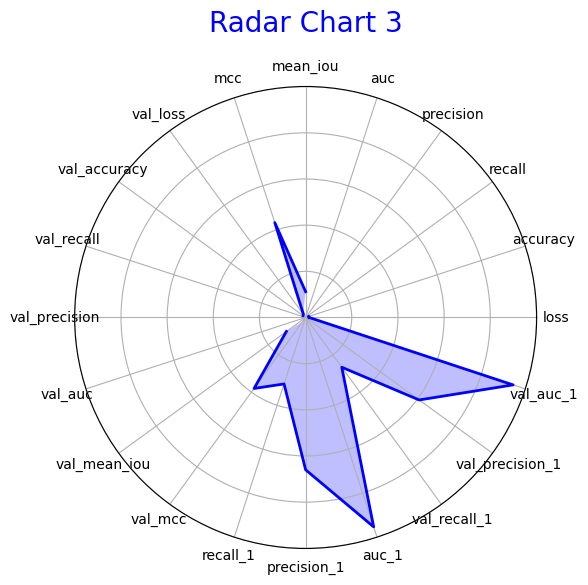

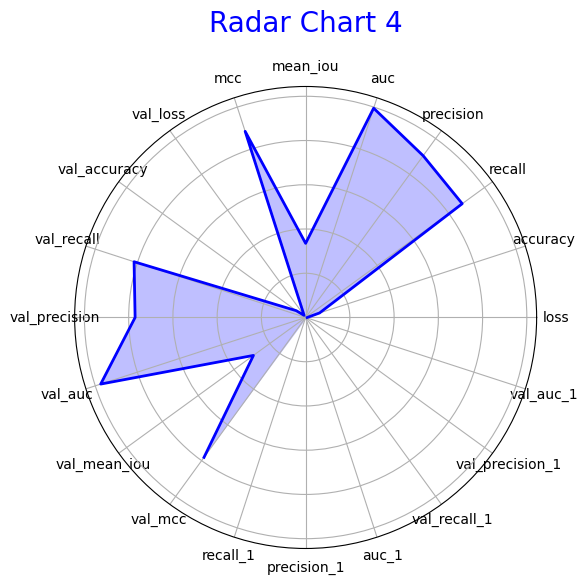

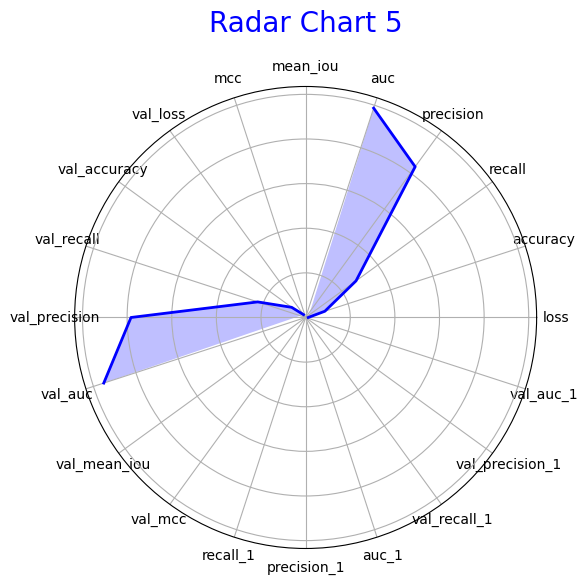

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data from five different CSV files into pandas DataFrames
file_paths = ["C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/alexnetnew.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/UNET123new.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/coatnetnew.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/lidcUnet50new.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/vgg19_customnew.csv"]
data_frames = [pd.read_csv(file) for file in file_paths]

# Assume each CSV has the same structure and the same columns
# For simplicity, we will take the mean of each column in each DataFrame
means = [df.mean() for df in data_frames]

# Combine the means into a single DataFrame
combined_df = pd.DataFrame(means)

# For the radar chart, we need to ensure the data is in the correct format
categories = combined_df.columns.tolist()
num_vars = len(categories)

# Create the angles for the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop for the radar chart
angles += angles[:1]

# Function to plot radar chart
def plot_radar(data, categories, title):
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # Repeat the first value to close the loop
    data = np.concatenate((data, [data[0]]))
    
    ax.fill(angles, data, color='b', alpha=0.25)
    ax.plot(angles, data, color='b', linewidth=2)
    ax.set_yticklabels([])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    
    plt.title(title, size=20, color='b', y=1.1)
    plt.show()

# Plot radar charts for each set of means
for i, row in combined_df.iterrows():
    plot_radar(row.values, categories, f'Radar Chart {i+1}')


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# List of CSV file paths
file_paths = ["C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/alexnetnew.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/UNET123new.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/coatnetnew.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/lidcUnet50new.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/vgg19_customnew.csv"]

# Initialize plot
plt.figure()

# Colors for different ROC curves
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

for i, file_path in enumerate(file_paths):
    # Load data
    data = pd.read_csv(file_path)
    
    # Assume the last column is the target variable
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train a logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Predict probabilities for the test set
    y_score = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'File {i+1} ROC curve (area = {roc_auc:.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for 5 CSV Files')
plt.legend(loc='lower right')

# Show the plot
plt.show()


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

<Figure size 640x480 with 0 Axes>

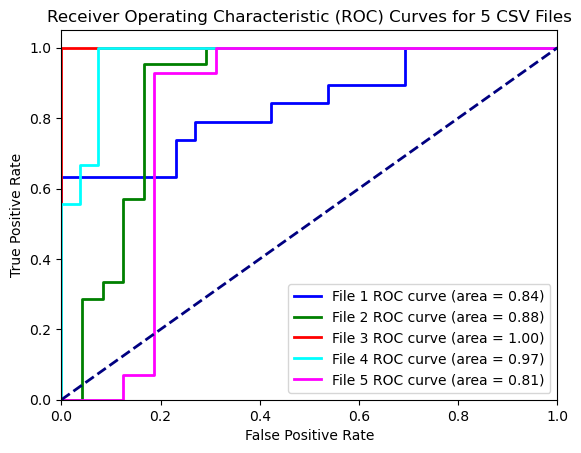

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# List of CSV file paths
file_paths = ["C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/alexnetnew.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/UNET123new.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/coatnetnew.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/lidcUnet50new.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/vgg19_customnew.csv"]

# Initialize plot
plt.figure()

# Colors for different ROC curves
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

for i, file_path in enumerate(file_paths):
    # Load data
    data = pd.read_csv(file_path)
    
    # Assume the last column is the target variable
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    
    # Check if the target is binary
    if len(np.unique(y)) != 2:
        # Convert to binary if it's continuous
        median = np.median(y)
        y = np.where(y > median, 1, 0)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train a logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Predict probabilities for the test set
    y_score = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'File {i+1} ROC curve (area = {roc_auc:.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for 5 CSV Files')
plt.legend(loc='lower right')

# Show the plot
plt.show()


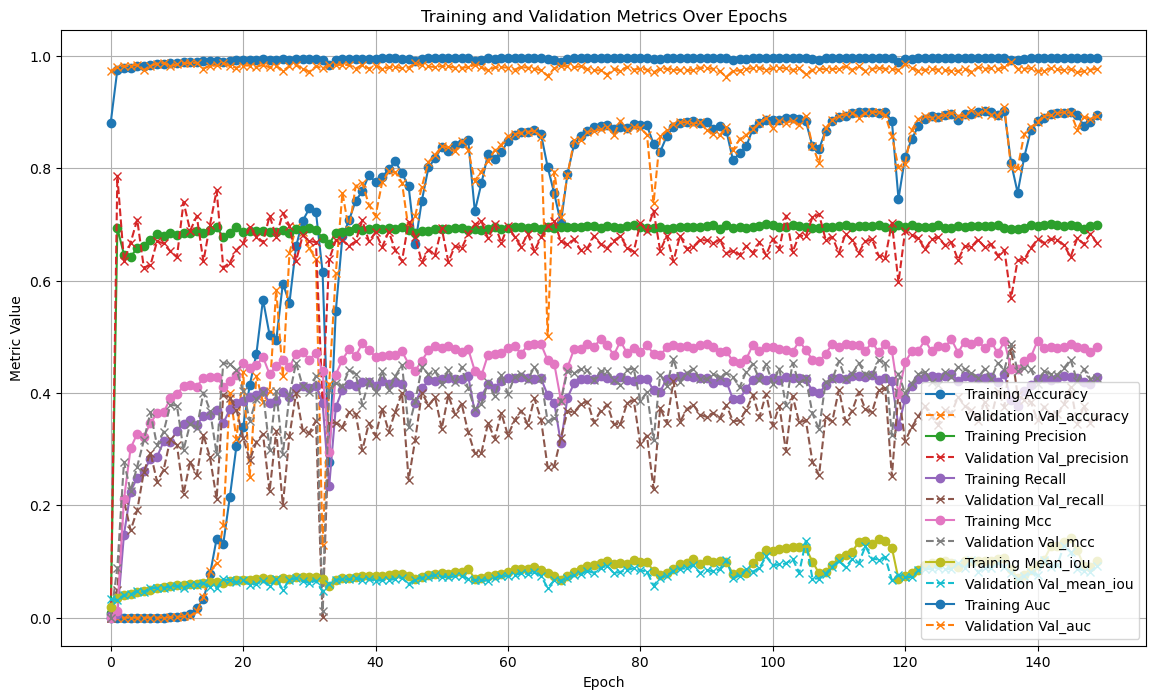

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/alexnetnew.csv"  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Define the metrics and their validation counterparts
metrics = ['accuracy', 'precision', 'recall', 'mcc', 'mean_iou', 'auc']
val_metrics = ['val_' + metric for metric in metrics]

# Plot the metrics
plt.figure(figsize=(14, 8))

for metric, val_metric in zip(metrics, val_metrics):
    plt.plot(data[metric], label=f'Training {metric.capitalize()}', marker='o')
    plt.plot(data[val_metric], label=f'Validation {val_metric.capitalize()}', linestyle='--', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training and Validation Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


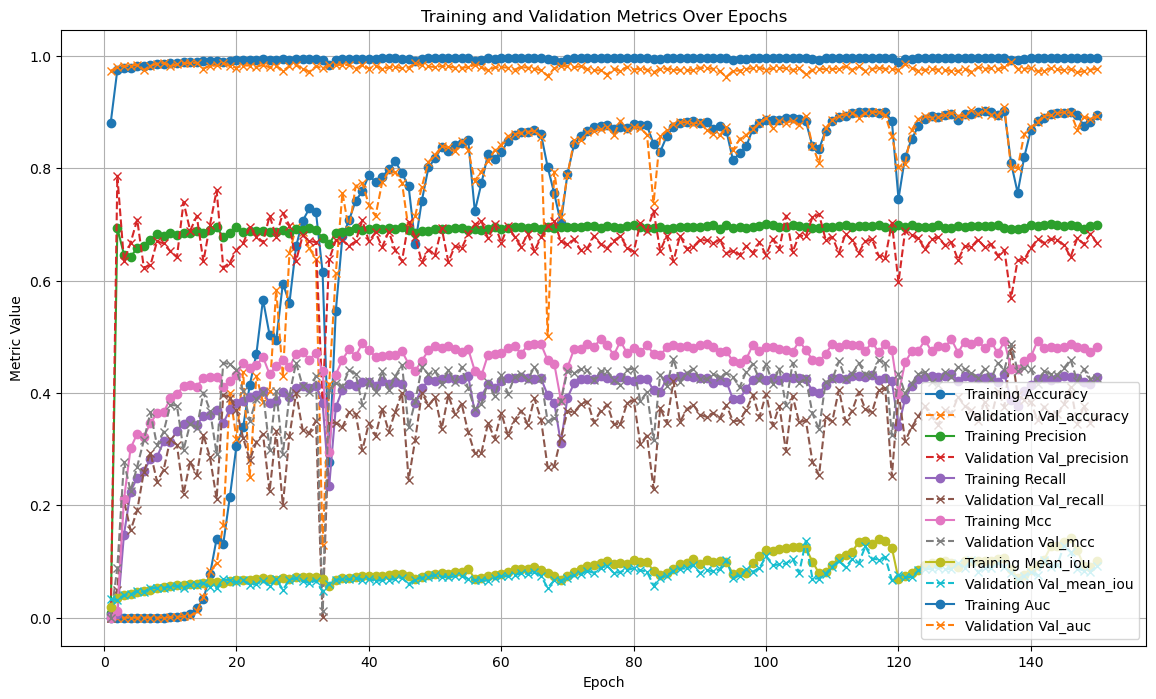

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path =  "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/alexnetnew.csv" # Replace with your CSV file path
data = pd.read_csv(file_path)

# Generate an epoch sequence based on the number of rows in the CSV file
epochs = range(1, len(data) + 1)

# Define the metrics and their validation counterparts
metrics = ['accuracy', 'precision', 'recall', 'mcc', 'mean_iou', 'auc']
val_metrics = ['val_' + metric for metric in metrics]

# Plot the metrics
plt.figure(figsize=(14, 8))

for metric, val_metric in zip(metrics, val_metrics):
    if metric in data.columns and val_metric in data.columns:
        plt.plot(epochs, data[metric], label=f'Training {metric.capitalize()}', marker='o')
        plt.plot(epochs, data[val_metric], label=f'Validation {val_metric.capitalize()}', linestyle='--', marker='x')
    else:
        print(f"Warning: {metric} or {val_metric} not found in the data.")

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training and Validation Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


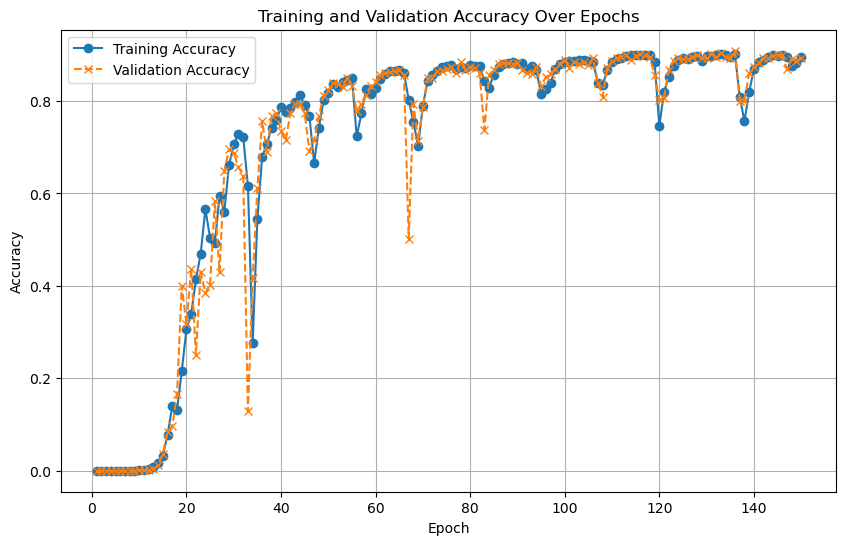

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/alexnetnew.csv"  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Generate an epoch sequence based on the number of rows in the CSV file
epochs = range(1, len(data) + 1)

# Check if the required columns exist
if 'accuracy' not in data.columns or 'val_accuracy' not in data.columns:
    raise KeyError('The CSV file must contain "accuracy" and "val_accuracy" columns.')

# Plot the accuracy
plt.figure(figsize=(10, 6))

plt.plot(epochs, data['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs, data['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


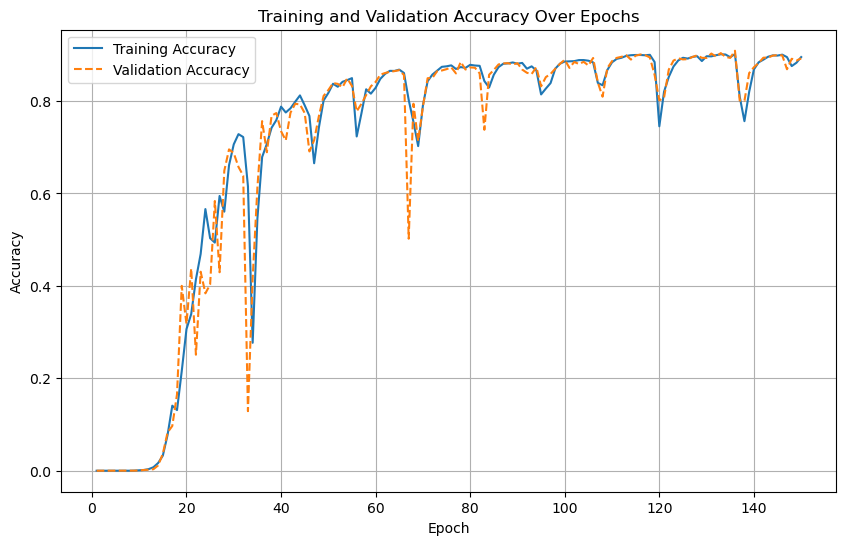

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/alexnetnew.csv" # Replace with your CSV file path
data = pd.read_csv(file_path)

# Generate an epoch sequence based on the number of rows in the CSV file
epochs = range(1, len(data) + 1)

# Check if the required columns exist
if 'accuracy' not in data.columns or 'val_accuracy' not in data.columns:
    raise KeyError('The CSV file must contain "accuracy" and "val_accuracy" columns.')

# Plot the accuracy
plt.figure(figsize=(10, 6))

plt.plot(epochs, data['accuracy'], label='Training Accuracy')
plt.plot(epochs, data['val_accuracy'], label='Validation Accuracy', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


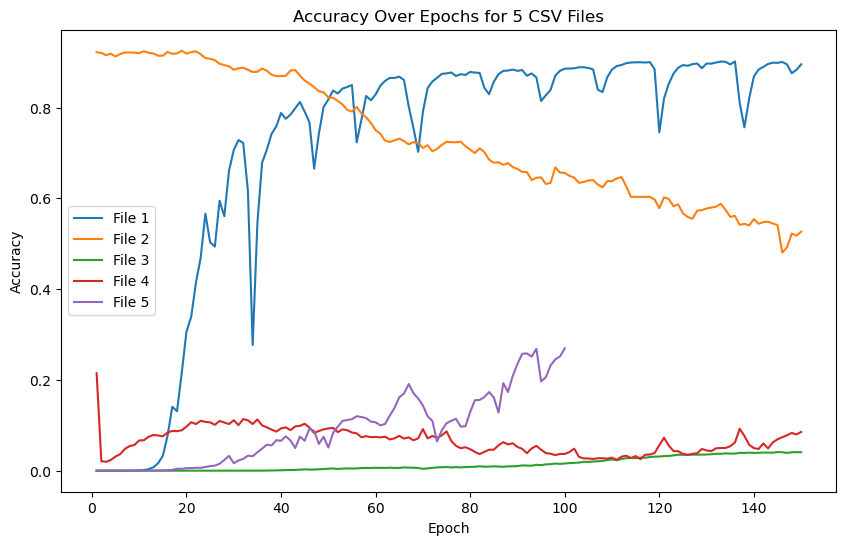

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# List of CSV file paths
file_paths = ["C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/alexnetnew.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/UNET123new.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/coatnetnew.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/lidcUnet50new.csv", "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/vgg19_customnew.csv"]

plt.figure(figsize=(10, 6))

# Iterate over each CSV file
for i, file_path in enumerate(file_paths):
    # Load the CSV file
    data = pd.read_csv(file_path)
    
    # Check if the required column exists
    if 'accuracy' not in data.columns:
        raise KeyError(f'The CSV file {file_path} must contain an "accuracy" column.')
    
    # Generate an epoch sequence based on the number of rows in the CSV file
    epochs = range(1, len(data) + 1)
    
    # Plot the accuracy
    plt.plot(epochs, data['accuracy'], label=f'File {i+1}')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs for 5 CSV Files')
plt.legend()
plt.show()


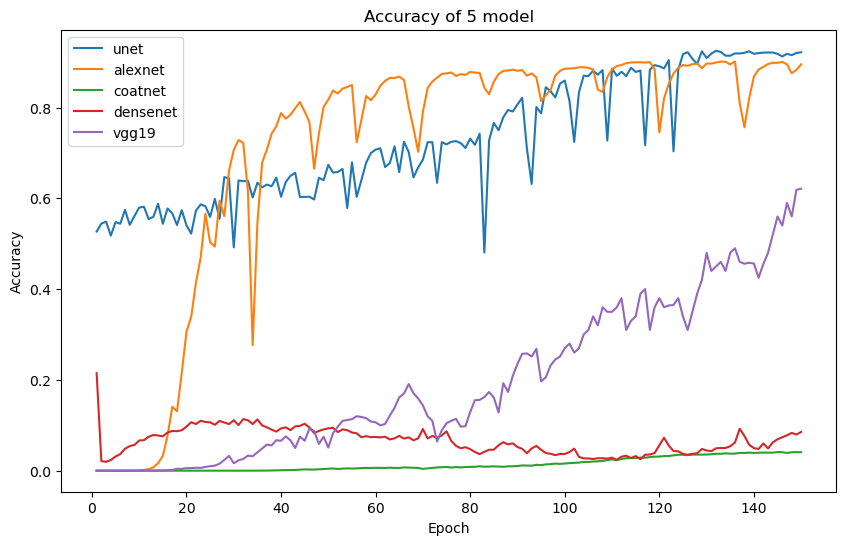

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# List of tuples containing custom labels and corresponding CSV file paths
file_info = [('unet', "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/UNET123new.csv"), ('alexnet', "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/alexnetnew.csv"), ('coatnet', "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/coatnetnew.csv"), ('densenet', "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/lidcUnet50new.csv"), ('vgg19', "C:/Users/nidhi/OneDrive/Desktop/paper/New folder/CSV/vgg19_customnew.csv")]

plt.figure(figsize=(10, 6))

# Iterate over each file info tuple
for label, file_path in file_info:
    # Load the CSV file
    data = pd.read_csv(file_path)
    
    # Check if the required column exists
    if 'accuracy' not in data.columns:
        raise KeyError(f'The CSV file {file_path} must contain an "accuracy" column.')
    
    # Generate an epoch sequence based on the number of rows in the CSV file
    epochs = range(1, len(data) + 1)
    
    # Plot the accuracy
    plt.plot(epochs, data['accuracy'], label=label)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy of 5 model')
plt.legend()
plt.show()


In [28]:
# Load the model
model = load_model('C:/Users/nidhi/OneDrive/Desktop/paper/New folder/MODEL/UNET123.h5' )

# Verify the model by printing its summary
model.summary()


ValueError: Unknown metric function: 'mean_iou'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [29]:
with tf.device('/gpu:0'):
    results = UNET123.fit(x_train,mask_train, validation_data=(x_test,mask_test), batch_size=32, epochs=150,)
UNET123.save(Name+'.h5')
model = UNET123

Epoch 1/150


KeyboardInterrupt: 

In [13]:
with tf.device('/gpu:0'):
    results = UNET123.fit(x_train,mask_train, validation_data=(x_test,mask_test), batch_size=32, epochs=150,)
UNET123.save(Name+'.h5')
model = UNET123

Epoch 1/150
251/251 [==============================] - 577s 2s/step - loss: 0.0172 - accuracy: 0.9217 - precision: 0.7551 - recall: 0.6114 - auc: 0.9880 - mean_iou: 0.1089 - mcc: 0.6739 - val_loss: 0.0170 - val_accuracy: 0.9625 - val_precision: 0.5622 - val_recall: 0.8527 - val_auc: 0.9944 - val_mean_iou: 0.1748 - val_mcc: 0.6824
Epoch 2/150
251/251 [==============================] - 560s 2s/step - loss: 0.0113 - accuracy: 0.9202 - precision: 0.7819 - recall: 0.6628 - auc: 0.9934 - mean_iou: 0.1502 - mcc: 0.7118 - val_loss: 0.0110 - val_accuracy: 0.9507 - val_precision: 0.6701 - val_recall: 0.8134 - val_auc: 0.9947 - val_mean_iou: 0.1937 - val_mcc: 0.7263
Epoch 3/150
251/251 [==============================] - 541s 2s/step - loss: 0.0090 - accuracy: 0.9153 - precision: 0.8047 - recall: 0.6908 - auc: 0.9945 - mean_iou: 0.1768 - mcc: 0.7391 - val_loss: 0.0098 - val_accuracy: 0.9619 - val_precision: 0.7675 - val_recall: 0.6602 - val_auc: 0.9819 - val_mean_iou: 0.1767 - val_mcc: 0.6964
Epoc

c:\Users\nidhi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
 pd.DataFrame.from_dict(results.history).to_csv(Name+'new.csv',index=False)

In [19]:
new_impr= UNET123.predict(x_train)

251/251 [==============================] - 99s 394ms/step


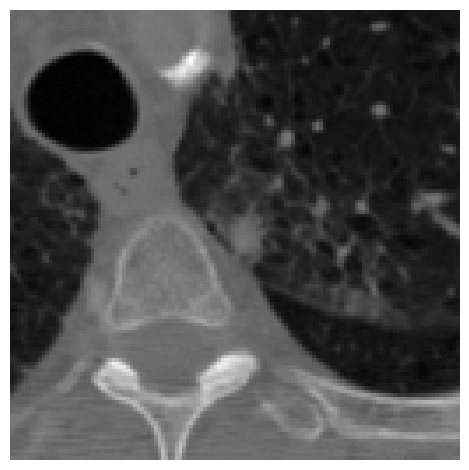

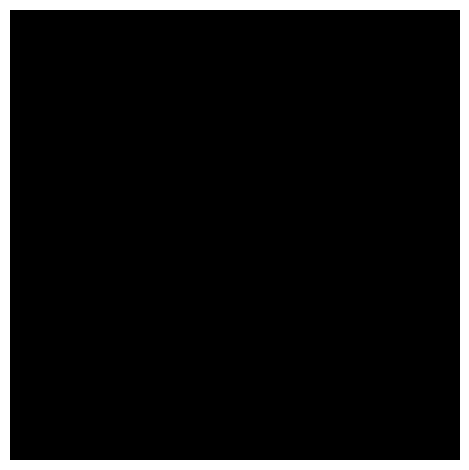

1/1 [==============================] - 0s 44ms/step


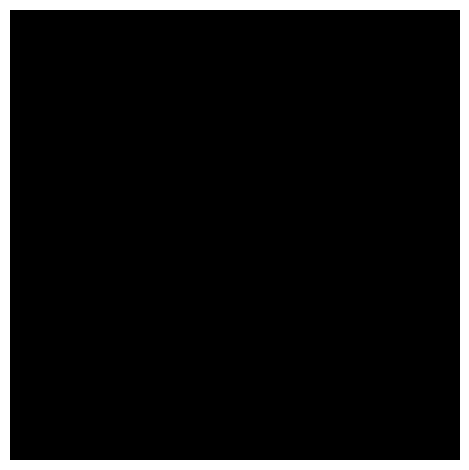

In [18]:

img_id=1019
new_img= np.array(x_train[img_id])
plt.imshow(x_train[img_id])
plt.axis('off')
plt.tight_layout()
plt.show()
plt.imshow(mask_train[img_id])
plt.axis('off')
plt.tight_layout()
plt.show()
new_img = new_img.reshape(1,128,128,3)
new_impr= model.predict(new_img)
plt.imshow(new_impr[0])
plt.axis('off')
plt.tight_layout()
#plt.savefig("Activation_Layer5D7"+'.png')
plt.show()


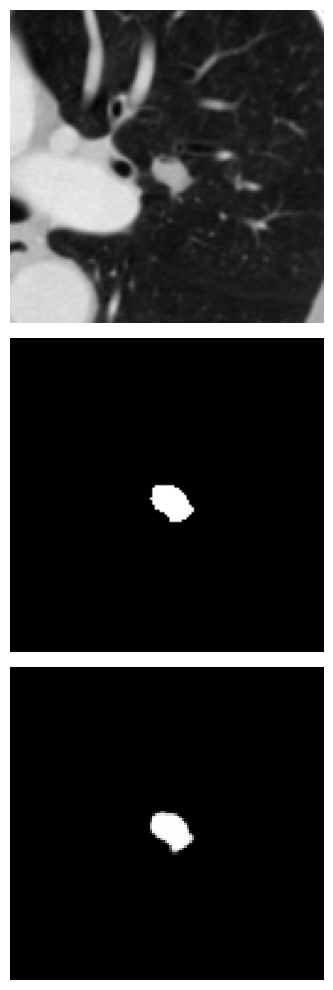

In [20]:
img_id=1789
fig = plt.figure(figsize=(10,10))
a = fig.add_subplot(3, 1, 1)
plt.imshow(x_train[img_id])
#a.set_title("original",fontsize=10)
plt.axis('off')
a = fig.add_subplot(3, 1, 2)
plt.imshow(mask_train[img_id])
#a.set_title("True Mask",fontsize=10)
plt.axis('off')
a = fig.add_subplot(3, 1, 3)
plt.imshow(new_impr[img_id],interpolation='nearest')
#a.set_title("Predicted",fontsize=10)
plt.axis('off')
plt.tight_layout()
plt.savefig("Segmentation"+str(img_id)+'.png')
plt.show()

In [21]:
# Assuming model is your trained model and x_test contains the test images
prediction = model.predict(x_test)
# Reshape y_score to match the shape of y_test
predictions_binary = prediction.max(axis=(1, 2, 3))
threshold = 0.65
predictions_binary = (predictions_binary > threshold).astype(np.uint8)

63/63 [==============================] - 26s 403ms/step


White area in mask_train: 157.5
White area in new_impr: 149.0


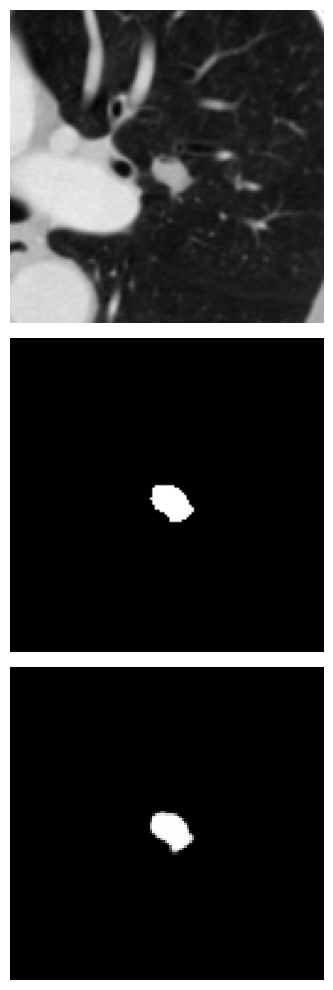

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define the threshold for binarization
threshold = 0.65

# Function to convert the mask to binary format
def binarize_mask(mask):
    return np.where(mask > threshold, 255, 0).astype(np.uint8)

# Function to find contours and compute area of white regions
def compute_white_area(mask):
    # Convert the mask to binary format
    binary_mask = binarize_mask(mask)
    # Convert the binary mask to a single-channel image
    binary_mask_single_channel = cv2.cvtColor(binary_mask, cv2.COLOR_RGB2GRAY)
    # Find contours of white regions
    contours, _ = cv2.findContours(binary_mask_single_channel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Compute total area of white regions
    total_area = sum(cv2.contourArea(contour) for contour in contours)
    return total_area

# Calculate white area for mask_train[img_id]
mask_train_white_area = compute_white_area(mask_train[img_id])
print("White area in mask_train:", mask_train_white_area)

# Calculate white area for new_impr[img_id]
new_impr_white_area = compute_white_area(new_impr[img_id])
print("White area in new_impr:", new_impr_white_area)

# Display the images
fig = plt.figure(figsize=(10,10))
a = fig.add_subplot(3, 1, 1)
plt.imshow(x_train[img_id])
plt.axis('off')

a = fig.add_subplot(3, 1, 2)
plt.imshow(mask_train[img_id])
plt.axis('off')

a = fig.add_subplot(3, 1, 3)
plt.imshow(new_impr[img_id], interpolation='nearest')
plt.axis('off')

plt.tight_layout()
plt.show()


***Confusion Matrix***

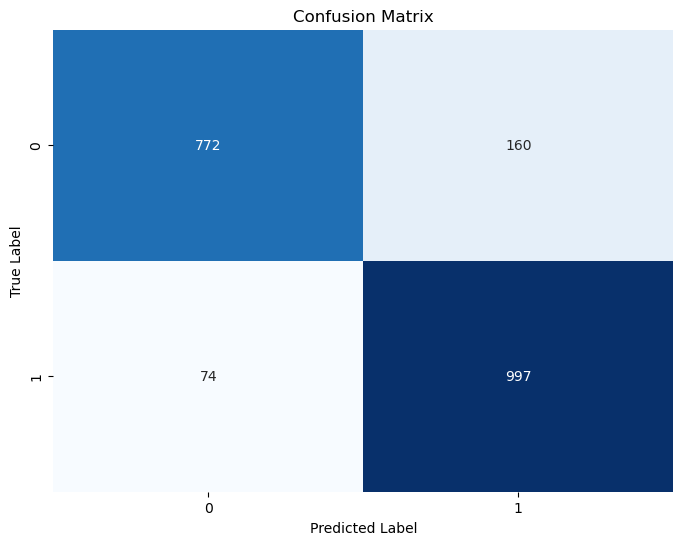

In [23]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)

# 4. Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


***Precision-Recall Curve***

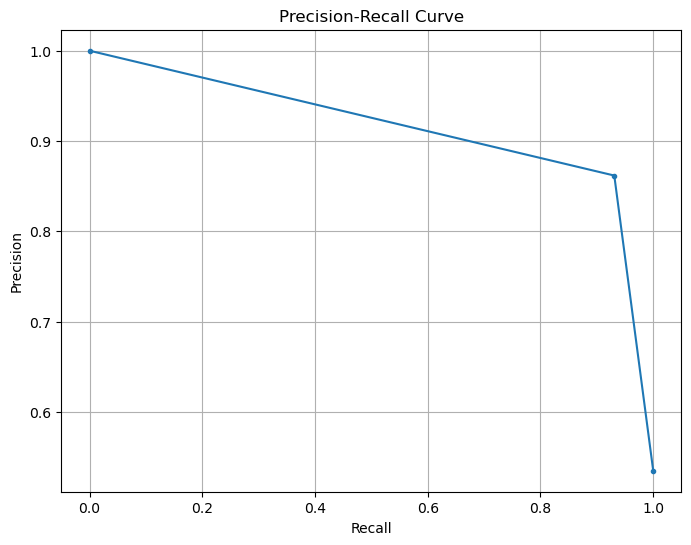

In [24]:

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, predictions_binary)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


***Receiver Operating Characteristic (ROC) Curve***

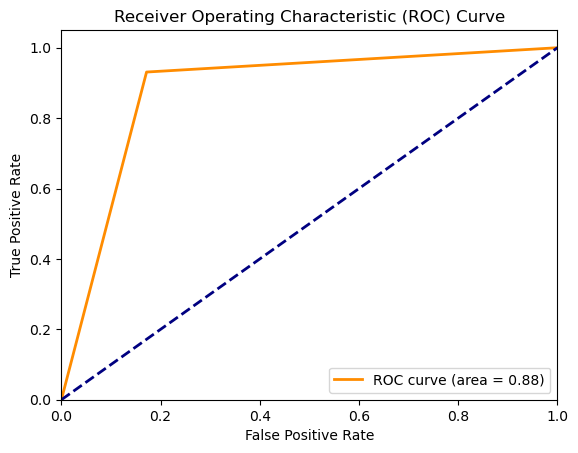

In [25]:

# Assuming y_test contains the true labels
fpr, tpr, thresholds = roc_curve(y_test, predictions_binary)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

***Accuracy vs. Threshold Plot***

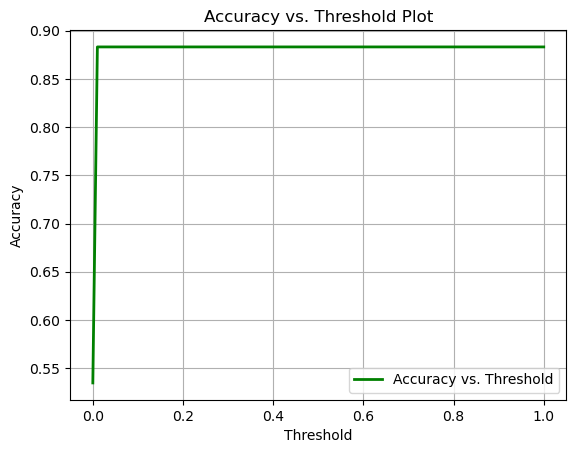

In [28]:

# Assuming y_test contains the true labels
# and y_score contains the predicted scores or probabilities
thresholds = np.linspace(0, 1, 100)
accuracies = []

for threshold in thresholds:
    y_pred = (predictions_binary >= threshold).astype(int)
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

# Plotting the Accuracy vs. Threshold plot
plt.figure()
plt.plot(thresholds, accuracies, color='green', lw=2, label='Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold Plot')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


***Classification report***

***Training and Validation mIoU***

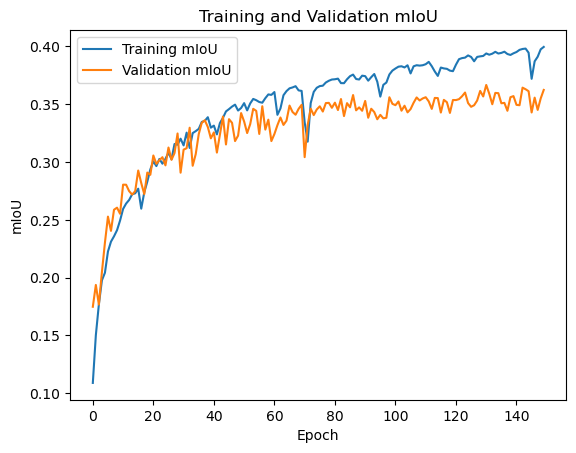

In [31]:


# Retrieve the mIoU values from the history object
train_miou = results.history['mean_iou']
val_miou = results.history['val_mean_iou']

# Plot mIoU values
plt.plot(train_miou, label='Training mIoU')
plt.plot(val_miou, label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and Validation mIoU')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Training and Validation\xa0Accuracy')

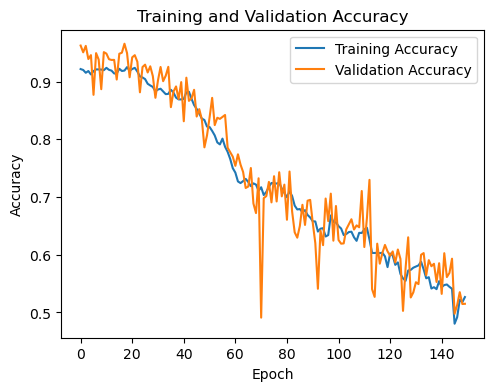

In [30]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot( results.history['accuracy'], label='Training Accuracy')
plt.plot( results.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')